In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ('ignore')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from numpy import mean
from numpy import std
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
#Reading the data
df = pd.read_csv("preprocessed_data.csv")

In [10]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2,stratify=df['Rating'] ,random_state=42)

y_train = X_train['Rating']

y_test = X_test['Rating']

# checking the shape 
print("Shape of train:", X_train.shape)
print("Shape of test: ", X_test.shape)

Shape of train: (127598, 9)
Shape of test:  (31900, 9)


In [5]:
df.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'usefulCount', 'Rating',
       'year', 'month', 'day'],
      dtype='object')

In [7]:
df.head(20)

,uniqueID,drugName,condition,review,usefulCount,Rating,year,month,day
0,206461,valsartan,left ventricular dysfunction,side effect take combination bystolic 5 mg fis...,27,1,2012,5,20
1,95260,guanfacine,adhd,son halfway fourth week intuniv became concern...,192,1,2010,4,27
2,92703,lybrel,birth control,used take another oral contraceptive 21 pill c...,17,0,2009,12,14
3,138000,ortho evra,birth control,first time using form birth control 039 glad w...,10,1,2015,11,3
4,35696,buprenorphine naloxone,opiate dependence,suboxone completely turned life around feel he...,37,1,2016,11,27
5,155963,cialis,benign prostatic hyperplasia,2nd day 5mg started work rock hard erections h...,43,0,2015,11,28
6,165907,levonorgestrel,emergency contraception,pulled cummed bit took plan b 26 hours later t...,5,0,2017,3,7
7,102654,aripiprazole,bipolar disorde,abilify changed life hope zoloft clonidine fir...,32,1,2015,3,14
8,74811,keppra,epilepsy,nothing problems keppera constant shaking arms...,11,0,2016,8,9
9,48928,ethinyl estradiol levonorgestrel,birth control,pill many years doctor changed rx chateal effe...,1,1,2016,12,8


In [6]:
#normalizing the column having numeric data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

In [37]:
normalizer.fit(X_train['uniqueID'].values.reshape(-1, 1))
X_train_normalized_uniqueID = normalizer.transform(X_train['uniqueID'].values.reshape(-1,1))
X_test_normalized_uniqueID = normalizer.transform(X_test['uniqueID'].values.reshape(-1,1))

normalizer.fit(X_train['usefulCount'].values.reshape(-1, 1))
X_train_normalized_usefulCount = normalizer.transform(X_train['usefulCount'].values.reshape(-1,1))
X_test_normalized_usefulCount = normalizer.transform(X_test['usefulCount'].values.reshape(-1,1))

normalizer.fit(X_train['year'].values.reshape(-1, 1))
X_train_normalized_year = normalizer.transform(X_train['year'].values.reshape(-1,1))
X_test_normalized_year = normalizer.transform(X_test['year'].values.reshape(-1,1))

normalizer.fit(X_train['month'].values.reshape(-1, 1))
X_train_normalized_month = normalizer.transform(X_train['month'].values.reshape(-1,1))
X_test_normalized_month = normalizer.transform(X_test['month'].values.reshape(-1,1))

normalizer.fit(X_train['day'].values.reshape(-1, 1))
X_train_normalized_day = normalizer.transform(X_train['day'].values.reshape(-1,1))
X_test_normalized_day = normalizer.transform(X_test['day'].values.reshape(-1,1))

In [38]:
#Response Coding
def responsedict(feature):
    #unique values of feature
    unique_labels = X_train[feature].unique()
    key = []
    val =[]
    for i in unique_labels:
       
        #Count where the target_variable is 1.
        positive = X_train.loc[:,feature][((X_train[feature] == i) & (y_train == 1))].count()
        #Count where the target_variable is 0.
        negative = X_train.loc[:,feature][((X_train[feature] == i) & (y_train == 0))].count()
        total_count = positive + negative
        #negative probability
        neg_prob = negative/total_count
        #positive probability
        pos_prob = positive/total_count
        key.append(i)
        val.append([neg_prob,pos_prob])
        
    prob_dict = dict(zip(key,val))
    
    return prob_dict

def feature_name(feature,df):
    feature_dict = responsedict(feature)
    #print(feature_dict)
    unique_label = X_train[feature].unique()
    fea = []
    for i,val  in df.iterrows():
        if val[feature] in unique_label:
            fea.append(feature_dict[val[feature]])
        else:
            fea.append([0.5,0.5])
   
    return fea

In [39]:
def hotencoder(dfeature):
    labelencoder = LabelEncoder()
    int_label_sub = labelencoder.fit_transform(dfeature)
    int_labe_sub = int_label_sub.reshape(len(int_label_sub),1)
    one_hot_encod_sub = OneHotEncoder(sparse=False)
    one_hot_enc = one_hot_encod_sub.fit_transform(int_labe_sub)
    return one_hot_enc

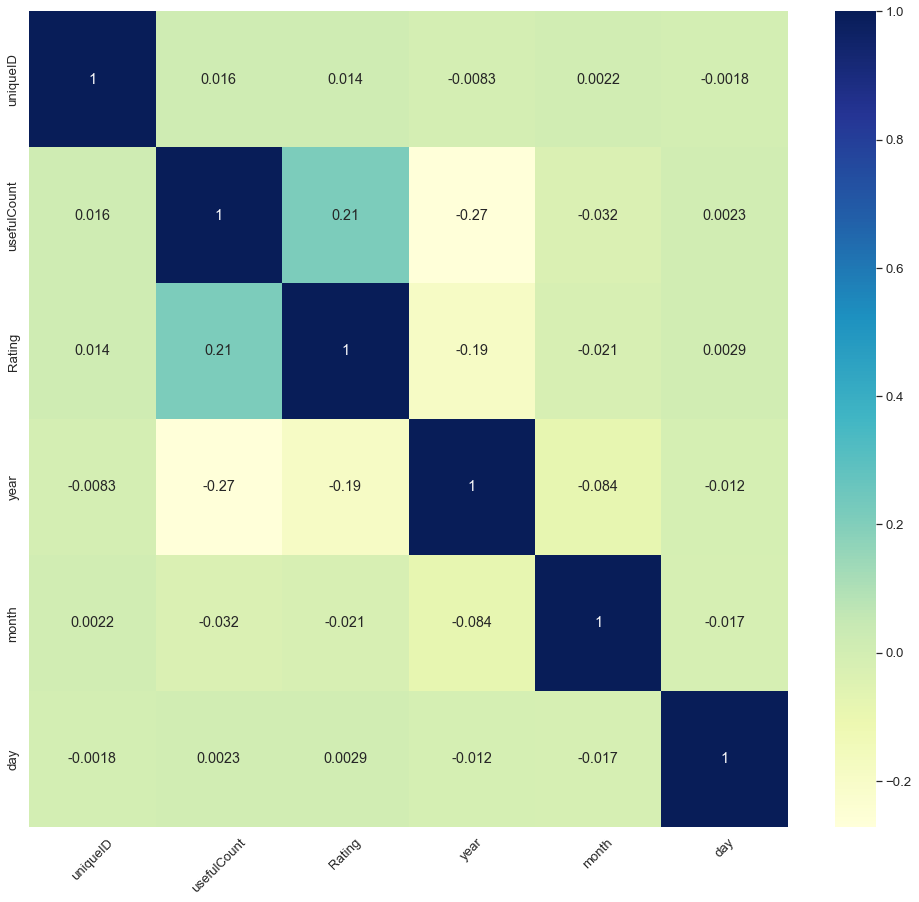

In [40]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = df.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [42]:
# Label Encoding Drugname and Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['drugName', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df[feature] = label_encoder_feat[feature].fit_transform(df[feature])

In [44]:
print('One-Hot Encoding')
train = pd.get_dummies(X_train, columns = ['Rating'])
print('On Train')
train.head()

One-Hot Encoding
On Train


,uniqueID,drugName,condition,review,usefulCount,year,month,day,Rating_0,Rating_1
111290,54710,bupropion naltrexone,obesity,started contrave today 039 5 039 8 female weig...,7,2017,3,27,1,0
128137,169287,diprivan,anesthesia,pain doctor gave 12 shots cervical spinal nerv...,24,2009,3,20,1,0
35049,225908,bupropion,bipolar disorde,tons better medicines like paxil depakote slee...,36,2010,3,6,0,1
97658,25987,kapvay,adhd,9 year old son adhd kapvay seventh medicine tr...,157,2012,5,15,0,1
154121,200233,varenicline,smoking cessation,fantastic quit smoking 20 years,22,2015,4,2,0,1


In [50]:
#one hot encoding
one_hot_enc_product_train =  hotencoder(X_train['Rating'])
one_hot_enc_product_test =  hotencoder(X_test['Rating'])
print("Rating",one_hot_enc_product_train.shape)

Rating (127598, 2)


In [51]:
#response coding
train_product_responseCoding=np.array(feature_name('Rating',X_train))
print(train_product_responseCoding.shape)
test_tproduct_responseCoding=np.array(feature_name('Rating',X_test))
print(test_tproduct_responseCoding.shape)

(127598, 2)
(31900, 2)


In [53]:
OneTrainXi = np.hstack((one_hot_enc_product_train))
OneTestXi = np.hstack((one_hot_enc_product_test))
print(OneTrainXi.shape)
print(OneTestXi.shape)
                        

(255196,)
(63800,)


In [54]:
from imblearn.over_sampling import SMOTE

#from sklearn.utils.metaestimators import available_if
ros =SMOTE(random_state=777)
ros_xtrain, ros_train_y = ros.fit_resample(OneTrainXi, y_train)

ModuleNotFoundError: No module named 'imblearn'

In [48]:
from sklearn.linear_model import LogisticRegression
# dict of parameters
grid={"C":np.logspace(-3,3,7),
     "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     "penalty": ['l1', 'l2'],
     "max_iter": [100,200,300]}
logreg=LogisticRegression()
#Random search
logreg_cv=RandomizedSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

ValueError: could not convert string to float: 'bupropion naltrexone'